In [3]:
def count_pixel(v):
    result = []
    cnt = 0
    last = -1
    for i in range(len(v)):
        if v[i] != last:
            if cnt > 0:
                result.append((last,cnt))
            last = v[i]
            cnt = 0
        cnt += 1
                
    result.append((last,cnt))
    return result

def compress_pixel(v,max,min):
    i = 0
    while i < len(v):
         
            
        #pruefe ob aktuelle Luecke klein ist
        px , cnt = v[i]
        if cnt > max: 
            i += 1 #wichtig
            continue
        
        if px == 0 and i == 0:
            i += 1 #wichtig
            continue #Rand mit Nullen ignorieren
        if px == 0 and i + 1 == len(v):
            i += 1 #wichtig
            continue #Rand mit Nullen ignorieren
            
        cnt_prev = 0
        #pruefe ob vorgaenger groß genug ist
        if i - 1 >= 0:
           _ , cnt_prev = v[i-1]
           if cnt_prev < min:
               i += 1 #wichtig
               continue
        cnt_next = 0     
        #pruefe ob nachfolger groß genug ist
        if i + 1 < len(v):
           _ , cnt_next = v[i+1]
           if cnt_next < min:
               i += 1 #wichtig
               continue
        
         
        #jetzt zusammenfassen
        #compress
        #i - 1 / i / i + 1
        new_cnt = cnt_prev + cnt + cnt_next
        v[i] = (255 - px , new_cnt)
        #nachfolger loeschen
        if i + 1 < len(v):
            del v[i+1]
        #vorgaenger löschen
        if i - 1 >= 0:
            del v[i-1]

           
        
def map2v(str):
    v = []
    for c in list(str):
        if c == '.':
            v.append(0)
        else:
            v.append(255)
    return v

def map2str(v):
    str = ""
    for p , c in v:
        if p == 0:
            str += "." * c 
        else:
            str += "#" * c 
    return str

def calculate_line(v):
    s = -1
    e = -1
    c = 0
    pos = 0
    w = 0
    for px , cnt in v:
        if px == 255:
            if s == -1:
                s = pos
            e = pos + cnt - 1
            c += cnt
        pos += cnt
        w += cnt
    return s , c , e ,w

def is_line_of_signal(v):
    min , cnt , max , w = calculate_line(v)
    border = w - min - max
    
    if cnt < border: return False
    if cnt < w/3: return False
    return True

def analyse_line(v,max,min):
    c = count_pixel(v)
    compress_pixel(c,max,min)
    return calculate_line(c)
    
def test(s1):
    v = map2v(s1)
    c = count_pixel(v)
    compress_pixel(c,3,4)
    s2 = map2str(c)
    calc = calculate_line(c)
    print(s1,"=>",s2,"calc",calc)
    
#Loecher in der Mitte entfernen            
test("....####.####.####...####....")
#Stoerngen am Anfang und Ende entfernen
test("#....################.....###")

test("#.#..###.....########..#..###")

test("..##.#.")
test(".....#.")
test(".......")
test("#######")
test("#..#")



....####.####.####...####.... => ....#####################.... calc (4, 21, 24, 29)
#....################.....### => .....################........ calc (5, 16, 20, 29)
#.#..###.....########..#..### => #.#..###.....########..#..### calc (0, 17, 28, 29)
..##.#. => ..##.#. calc (2, 3, 5, 7)
.....#. => .....#. calc (5, 1, 5, 7)
....... => ....... calc (-1, 0, -1, 7)
####### => ####### calc (0, 7, 6, 7)
#..# => #..# calc (0, 2, 3, 4)


In [8]:
import numpy as np
import imutils
import cv2

import matplotlib.pyplot as plt

from signal_aspect_detection.find_polygones import *


from signal_aspect_detection.image_accessor_class import HorizontalImageAccessor , VerticalImageAccessor

    
    
def crop_image_line3(imageAccessor, thres_width , threas_thickness):   #sr - scan rows
    
    thickness = 0
    line_length = imageAccessor.get_line_length()
    lines_cnt = imageAccessor.get_lines_cnt()
    min_width = round(line_length * thres_width)
    min_thickness = round(lines_cnt * threas_thickness)
    max_hole_size = 11
    min_area_size = 13
    h = []
    for line in range(lines_cnt):
        v = []
        for x in range(line_length):
            b = imageAccessor.get_bin(line,x)  
            v.append(b)

        # test line 
        #print("v",v)
        r = count_pixel(v)
        #compress_pixel(r,max_hole_size,min_area_size)
   
        pixel = 0        
        if is_line_of_signal(r): 
            pixel = 255
        h.append(pixel)
    
    return count_pixel(h)

def combine_ranges(r1,r2):
    boxes = []
    pos1 = 0
    for px1 , cnt1 in r1:
        if px1 == 255 and cnt1 > 5:
            s1 = pos1
            e1 = pos1 + cnt1 - 1
            pos2 = 0
            for px2 , cnt2 in r2:
                if px2 == 255 and cnt2 > 5:
                    s2 = pos2
                    e2 = pos2 + cnt2 - 1
                    boxes.append((s1,e1,s2,e2))
                pos2 += cnt2
        pos1 += cnt1
    return boxes

def crop_signal3(image):

    #thresholds mindestbreit 50% 
    width , thickness = 0.5 , 0.8

    r1 = crop_image_line3(VerticalImageAccessor(image),width , thickness)
    r2 = crop_image_line3(HorizontalImageAccessor(image),width , thickness)
    
    boxes = combine_ranges(r1,r2)
    
    print("crop",r1,r2)
    print("boxes",boxes)
    
    
    max_box = (-1,-1,-1,-1)
    max_size = 0

    for box in boxes:
        sz = (box[1] - box[0]) *  (box[3] - box[2]) 
        if sz > max_size:
            max_box = box
            max_size = sz
    
    return max_box

def create_binary(image,val):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    if val > 0:
        thresh = cv2.threshold(blurred, val, 255, cv2.THRESH_BINARY)[1]
    else:
        thresh = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

    
    threshi = cv2.bitwise_not(thresh)
    return threshi


def paint_polygones2(image,polygones):
    for polygon in polygones:
        #cv2.drawContours(image, polygon.contours, -1, color=(255, 255, 0), thickness=3) #thickness=cv2.FILLED
        cv2.polylines(image, [polygon.polyline], True, (255,255,0), thickness=3) 
        x , y , w , h = polygon.rectangle
        cv2.rectangle(image, (x,y), (x + w,y + h), (0,0,255), thickness = 5)  
        
        

    

     
def handle_image(filename):
    print(filename)
    org = cv2.imread(filename)
    image = cv2.cvtColor(org, cv2.COLOR_BGR2RGB)

    resized = imutils.resize(image, width=100)   

    
    images = []
    images.append(resized)
    val = -1 #30,40,-1,50,60,90,120,150
    binary_img = create_binary(resized,val)

      
        
    rows , columns = binary_img.shape[0] , binary_img.shape[1] 
    (left,right,top,bottom) = crop_signal3(binary_img)
    
    print("crop",(left,right,top,bottom))

    #fix crop if not found
    if left == -1: left = 0
    if right == -1: right = columns
    if top == -1: top = 0
    if bottom == -1: bottom = rows

    img = np.zeros((binary_img.shape[0], binary_img.shape[1], 3), dtype = "uint8")
    color = (255,255,0)
    cv2.line(img,(0,top),(columns-1,top),color,thickness = 1)
    cv2.line(img,(0,bottom),(columns-1,bottom),color,thickness = 1)
    cv2.line(img,(left,0),(left,rows-1),color,thickness = 1)
    cv2.line(img,(right,0),(right,rows-1),color,thickness = 1)

        
    #polygon
    #polygones = detect_polygones(binary_img)
    #print(len(polygones)," polygones detected")
    #for p in polygones:
    #    print("P",len(p.polyline),p.rectangle)
            
    #polygon_img = np.zeros((binary_img.shape[0], binary_img.shape[1], 3), dtype = "uint8")
    #paint_polygones2(polygon_img,polygones)
    #images.append(polygon_img)

        
        
    images.append(binary_img)
    images.append(img)

    
    #dump
    l = len(images)
    fig, axs = plt.subplots(nrows=1, ncols=l) 
    for i in range(l):
        axs[i].axis('off')
        axs[i].imshow(images[i])
    plt.show()
    
 

../data/drohne-signals/traffic_light0010.png
crop [(255, 100)] [(0, 3), (255, 142), (0, 16), (255, 28)]
boxes [(0, 99, 3, 144), (0, 99, 161, 188)]
crop (0, 99, 3, 144)


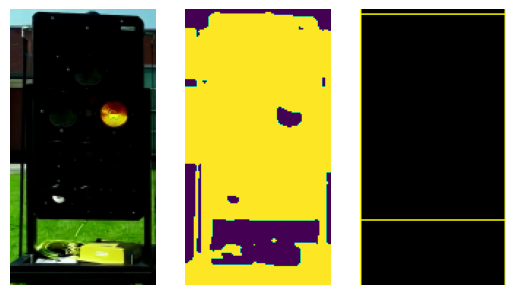

In [9]:
handle_image("../data/drohne-signals/traffic_light0010.png")

../data/crop_improve/01_original.png
crop [(0, 3), (255, 90), (0, 7)] [(0, 7), (255, 161)]
boxes [(3, 92, 7, 167)]
crop (3, 92, 7, 167)


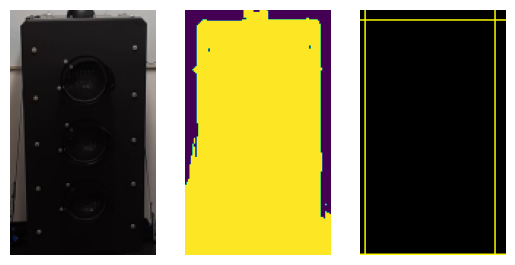

../data/crop_improve/115_original.png
crop [(255, 86), (0, 14)] [(0, 15), (255, 251)]
boxes [(0, 85, 15, 265)]
crop (0, 85, 15, 265)


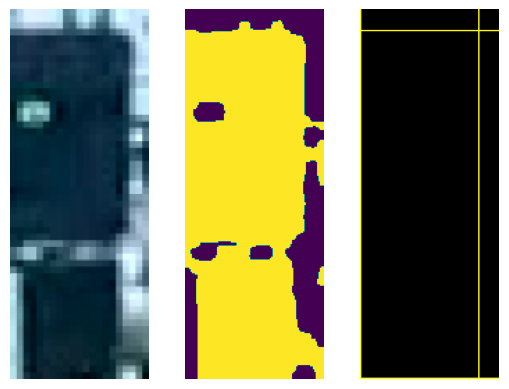

../data/crop_improve/256_original.png
crop [(255, 93), (0, 7)] [(255, 258), (0, 10), (255, 16)]
boxes [(0, 92, 0, 257), (0, 92, 268, 283)]
crop (0, 92, 0, 257)


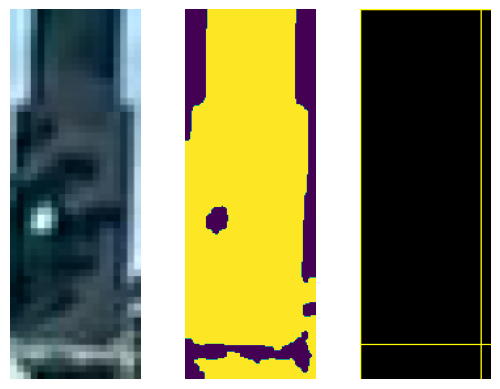

../data/crop_improve/35_original.png
crop [(0, 11), (255, 74), (0, 15)] [(255, 2), (0, 9), (255, 124), (0, 20), (255, 3), (0, 6), (255, 6)]
boxes [(11, 84, 11, 134), (11, 84, 164, 169)]
crop (11, 84, 11, 134)


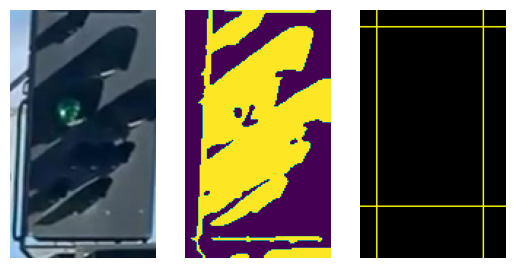

../data/crop_improve/44_original.png
crop [(0, 16), (255, 84)] [(255, 8), (0, 24), (255, 6), (0, 1), (255, 1), (0, 7), (255, 207), (0, 15), (255, 84), (0, 30), (255, 9)]
boxes [(16, 99, 0, 7), (16, 99, 32, 37), (16, 99, 47, 253), (16, 99, 269, 352), (16, 99, 383, 391)]
crop (16, 99, 47, 253)


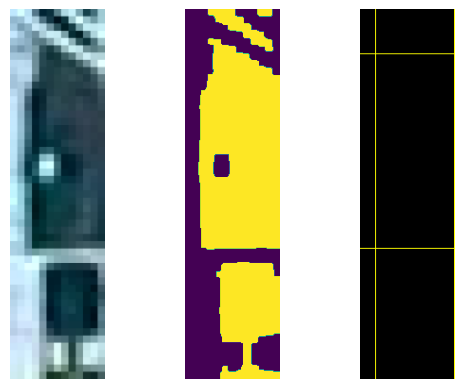

../data/crop_improve/kshauptsignal2_Ks2_vBw.png
crop [(0, 4), (255, 92), (0, 4)] [(0, 10), (255, 190)]
boxes [(4, 95, 10, 199)]
crop (4, 95, 10, 199)


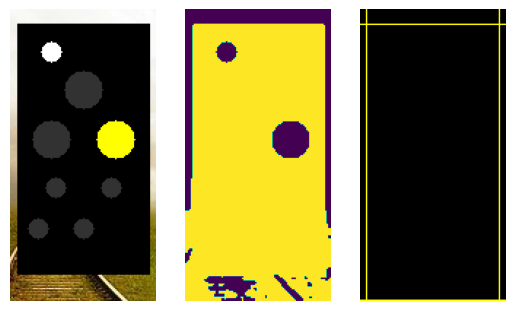

../data/crop_improve/scheibenberg.png
crop [(255, 100)] [(255, 144), (0, 1), (255, 32), (0, 2), (255, 1)]
boxes [(0, 99, 0, 143), (0, 99, 145, 176)]
crop (0, 99, 0, 143)


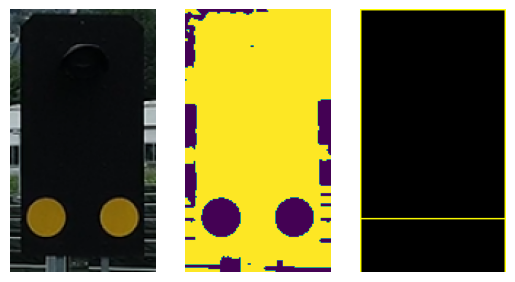

../data/crop_improve/traffic_light0005.png
crop [(0, 5), (255, 88), (0, 7)] [(0, 12), (255, 195)]
boxes [(5, 92, 12, 206)]
crop (5, 92, 12, 206)


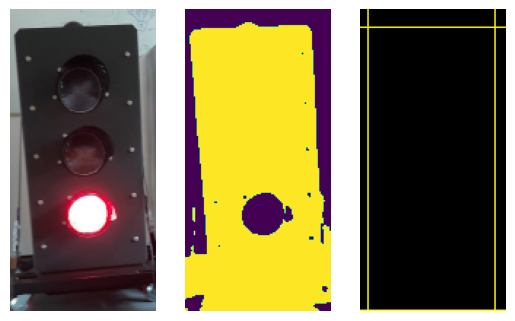

../data/crop_improve/traffic_light0006.png
crop [(255, 100)] [(0, 4), (255, 208)]
boxes [(0, 99, 4, 211)]
crop (0, 99, 4, 211)


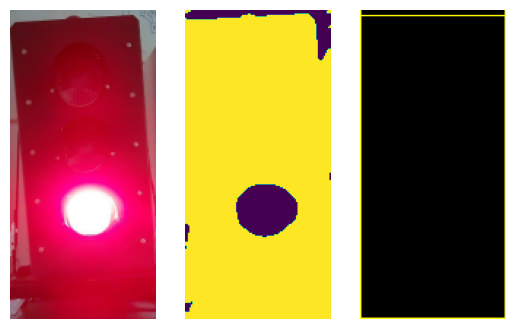

../data/crop_improve/traffic_light0011.png
crop [(255, 95), (0, 5)] [(255, 146), (0, 13), (255, 6), (0, 5), (255, 4)]
boxes [(0, 94, 0, 145), (0, 94, 159, 164)]
crop (0, 94, 0, 145)


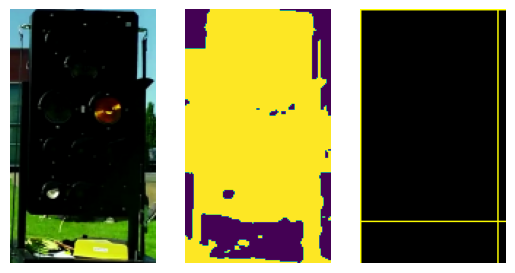

../data/crop_improve/traffic_light0032.png
crop [(255, 100)] [(255, 165), (0, 19)]
boxes [(0, 99, 0, 164)]
crop (0, 99, 0, 164)


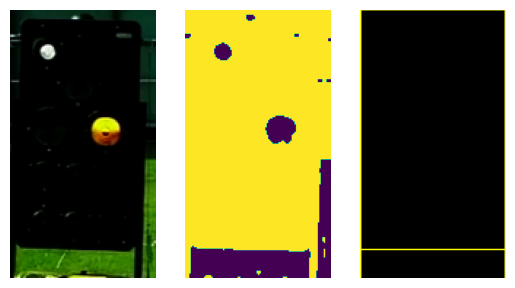

In [6]:
from os import listdir
path = "../data/crop_improve/"
for filename in listdir(path):
        handle_image(path + filename)

../data/drohne-signals/traffic_light0001.png
crop [(0, 4), (255, 96)] [(255, 110)]
boxes [(4, 99, 0, 109)]
crop (4, 99, 0, 109)


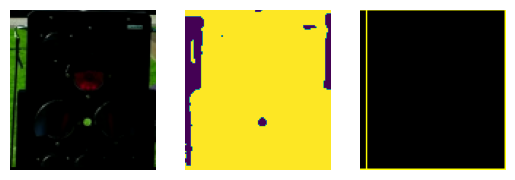

../data/drohne-signals/traffic_light0002.png
crop [(0, 6), (255, 94)] [(0, 7), (255, 136)]
boxes [(6, 99, 7, 142)]
crop (6, 99, 7, 142)


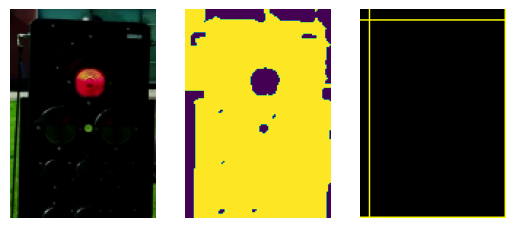

../data/drohne-signals/traffic_light0003.png
crop [(255, 100)] [(0, 10), (255, 155), (0, 11), (255, 20)]
boxes [(0, 99, 10, 164), (0, 99, 176, 195)]
crop (0, 99, 10, 164)


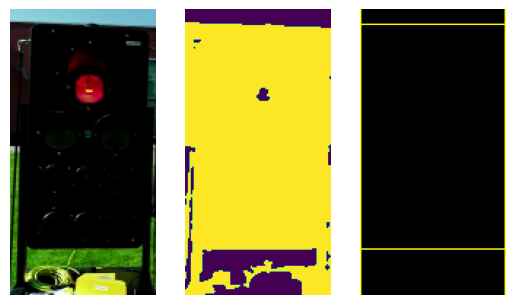

../data/drohne-signals/traffic_light0004.png
crop [(255, 100)] [(0, 12), (255, 156), (0, 7), (255, 2), (0, 1), (255, 19), (0, 1)]
boxes [(0, 99, 12, 167), (0, 99, 178, 196)]
crop (0, 99, 12, 167)


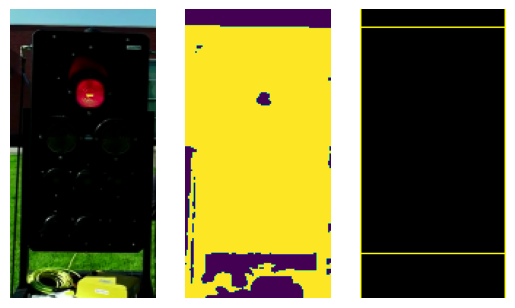

../data/drohne-signals/traffic_light0005.png
crop [(255, 2), (0, 2), (255, 96)] [(255, 167), (0, 13), (255, 7)]
boxes [(4, 99, 0, 166), (4, 99, 180, 186)]
crop (4, 99, 0, 166)


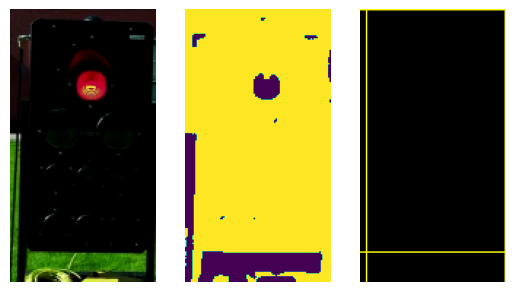

../data/drohne-signals/traffic_light0006.png
crop [(255, 100)] [(0, 3), (255, 162), (0, 11)]
boxes [(0, 99, 3, 164)]
crop (0, 99, 3, 164)


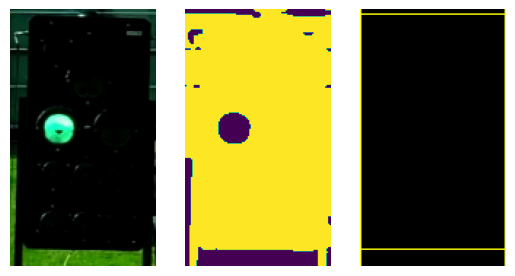

../data/drohne-signals/traffic_light0007.png
crop [(255, 100)] [(255, 176), (0, 24), (255, 5)]
boxes [(0, 99, 0, 175)]
crop (0, 99, 0, 175)


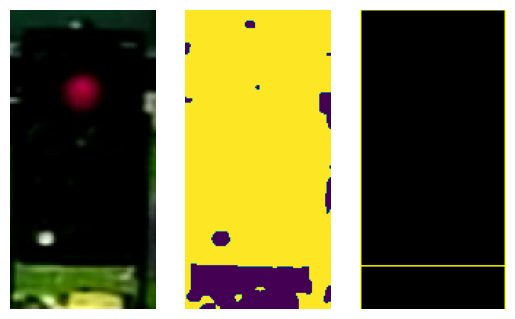

../data/drohne-signals/traffic_light0008.png
crop [(255, 100)] [(255, 188)]
boxes [(0, 99, 0, 187)]
crop (0, 99, 0, 187)


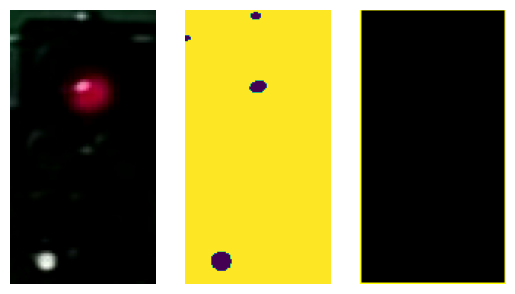

../data/drohne-signals/traffic_light0009.png
crop [(255, 100)] [(255, 161)]
boxes [(0, 99, 0, 160)]
crop (0, 99, 0, 160)


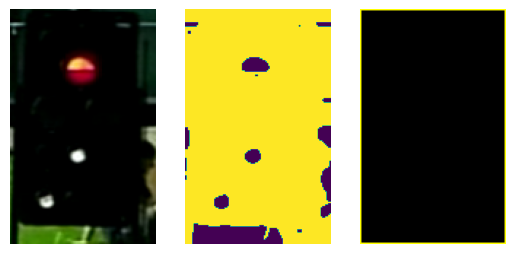

../data/drohne-signals/traffic_light0010.png
crop [(255, 100)] [(0, 3), (255, 142), (0, 16), (255, 28)]
boxes [(0, 99, 3, 144), (0, 99, 161, 188)]
crop (0, 99, 3, 144)


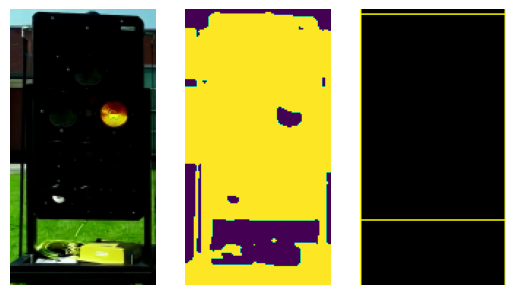

../data/drohne-signals/traffic_light0011.png
crop [(255, 95), (0, 5)] [(255, 146), (0, 13), (255, 6), (0, 5), (255, 4)]
boxes [(0, 94, 0, 145), (0, 94, 159, 164)]
crop (0, 94, 0, 145)


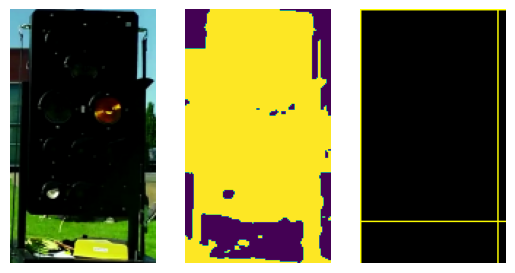

../data/drohne-signals/traffic_light0012.png
crop [(255, 98), (0, 2)] [(255, 153), (0, 11), (255, 13), (0, 4), (255, 11)]
boxes [(0, 97, 0, 152), (0, 97, 164, 176), (0, 97, 181, 191)]
crop (0, 97, 0, 152)


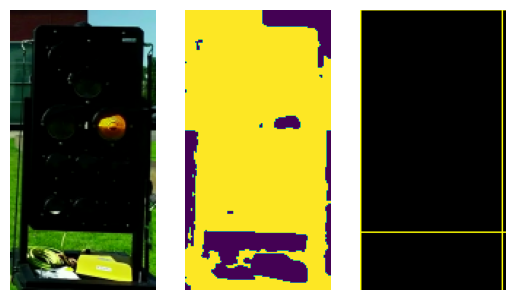

../data/drohne-signals/traffic_light0013.png
crop [(255, 95), (0, 5)] [(255, 149), (0, 11), (255, 12), (0, 5), (255, 12)]
boxes [(0, 94, 0, 148), (0, 94, 160, 171), (0, 94, 177, 188)]
crop (0, 94, 0, 148)


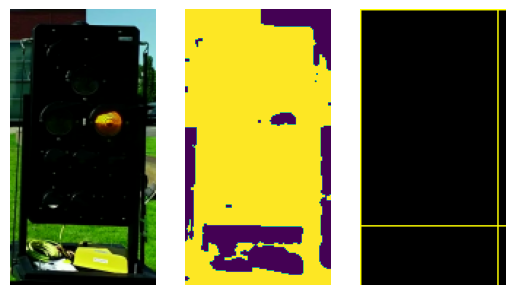

../data/drohne-signals/traffic_light0014.png
crop [(255, 92), (0, 8)] [(255, 149), (0, 11), (255, 12), (0, 5), (255, 8)]
boxes [(0, 91, 0, 148), (0, 91, 160, 171), (0, 91, 177, 184)]
crop (0, 91, 0, 148)


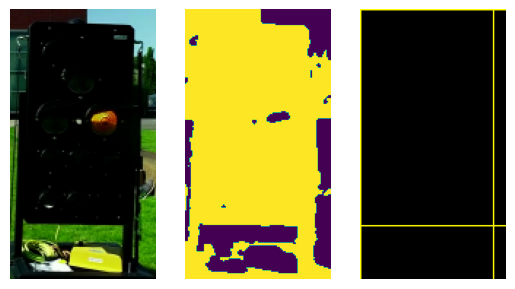

../data/drohne-signals/traffic_light0015.png
crop [(0, 2), (255, 93), (0, 5)] [(255, 149), (0, 11), (255, 17)]
boxes [(2, 94, 0, 148), (2, 94, 160, 176)]
crop (2, 94, 0, 148)


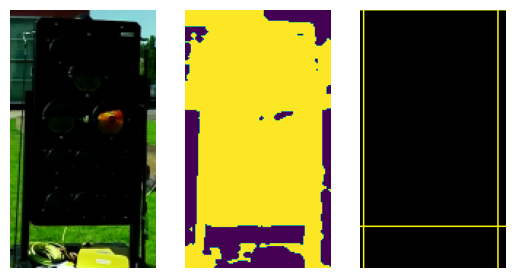

../data/drohne-signals/traffic_light0016.png
crop [(255, 96), (0, 4)] [(255, 152), (0, 11), (255, 15)]
boxes [(0, 95, 0, 151), (0, 95, 163, 177)]
crop (0, 95, 0, 151)


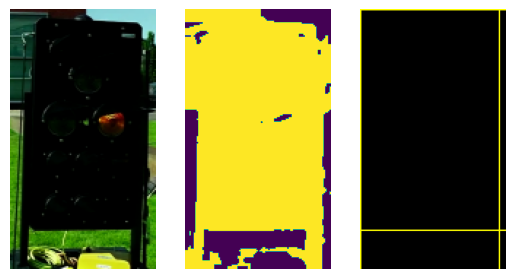

../data/drohne-signals/traffic_light0017.png
crop [(0, 7), (255, 93)] [(255, 155), (0, 9)]
boxes [(7, 99, 0, 154)]
crop (7, 99, 0, 154)


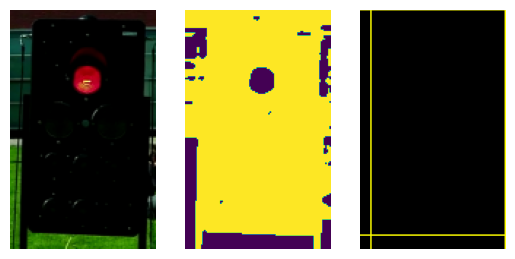

../data/drohne-signals/traffic_light0018.png
crop [(255, 100)] [(255, 158), (0, 13), (255, 12), (0, 4), (255, 21)]
boxes [(0, 99, 0, 157), (0, 99, 171, 182), (0, 99, 187, 207)]
crop (0, 99, 0, 157)


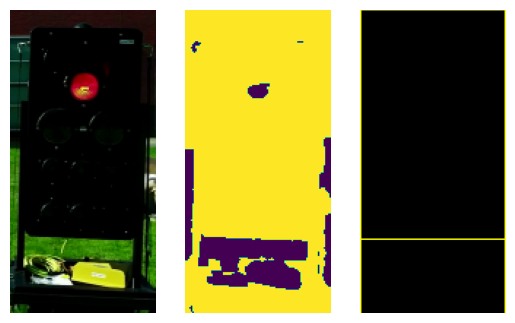

../data/drohne-signals/traffic_light0019.png
crop [(255, 100)] [(255, 167), (0, 13), (255, 13), (0, 4), (255, 16)]
boxes [(0, 99, 0, 166), (0, 99, 180, 192), (0, 99, 197, 212)]
crop (0, 99, 0, 166)


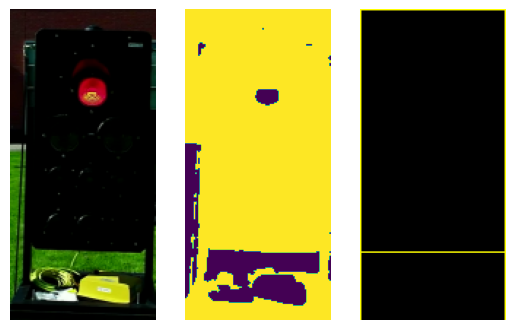

../data/drohne-signals/traffic_light0020.png
crop [(255, 100)] [(255, 154), (0, 12), (255, 13), (0, 3), (255, 5)]
boxes [(0, 99, 0, 153), (0, 99, 166, 178)]
crop (0, 99, 0, 153)


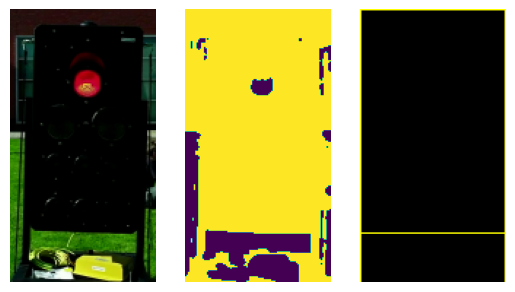

../data/drohne-signals/traffic_light0021.png
crop [(255, 100)] [(255, 148), (0, 13), (255, 12), (0, 4), (255, 5)]
boxes [(0, 99, 0, 147), (0, 99, 161, 172)]
crop (0, 99, 0, 147)


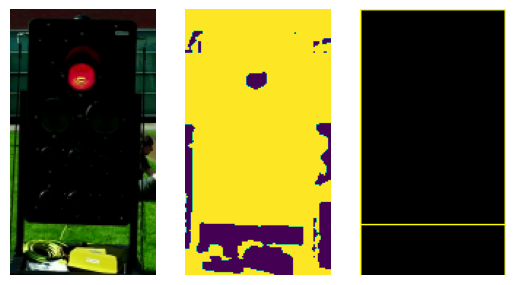

../data/drohne-signals/traffic_light0022.png
crop [(255, 100)] [(255, 154), (0, 13), (255, 13), (0, 2), (255, 4)]
boxes [(0, 99, 0, 153), (0, 99, 167, 179)]
crop (0, 99, 0, 153)


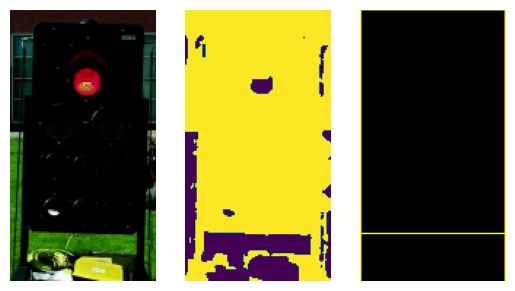

../data/drohne-signals/traffic_light0023.png
crop [(255, 100)] [(255, 142), (0, 12), (255, 12), (0, 4), (255, 8)]
boxes [(0, 99, 0, 141), (0, 99, 154, 165), (0, 99, 170, 177)]
crop (0, 99, 0, 141)


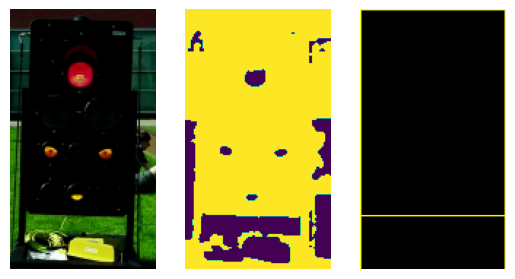

../data/drohne-signals/traffic_light0024.png
crop [(0, 3), (255, 97)] [(255, 146), (0, 12), (255, 12), (0, 4), (255, 4)]
boxes [(3, 99, 0, 145), (3, 99, 158, 169)]
crop (3, 99, 0, 145)


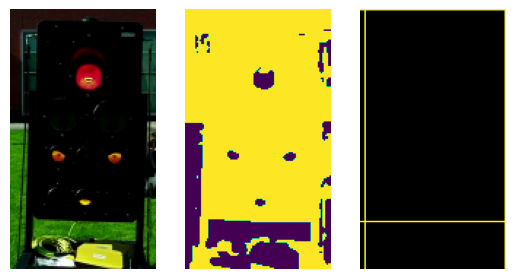

../data/drohne-signals/traffic_light0025.png
crop [(0, 1), (255, 99)] [(255, 148), (0, 13), (255, 11), (0, 4), (255, 7)]
boxes [(1, 99, 0, 147), (1, 99, 161, 171), (1, 99, 176, 182)]
crop (1, 99, 0, 147)


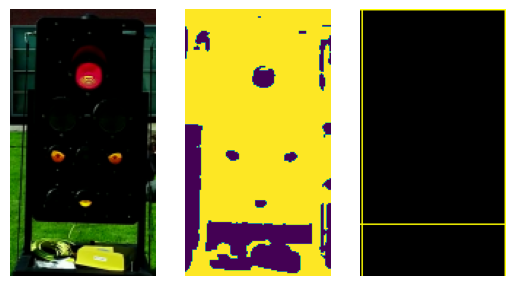

../data/drohne-signals/traffic_light0026.png
crop [(0, 1), (255, 99)] [(255, 119), (0, 12), (255, 1), (0, 2), (255, 3), (0, 6), (255, 6)]
boxes [(1, 99, 0, 118), (1, 99, 143, 148)]
crop (1, 99, 0, 118)


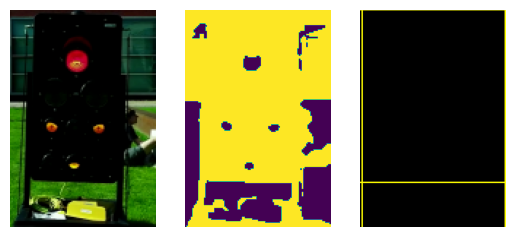

../data/drohne-signals/traffic_light0027.png
crop [(0, 4), (255, 96)] [(255, 111), (0, 22), (255, 6)]
boxes [(4, 99, 0, 110), (4, 99, 133, 138)]
crop (4, 99, 0, 110)


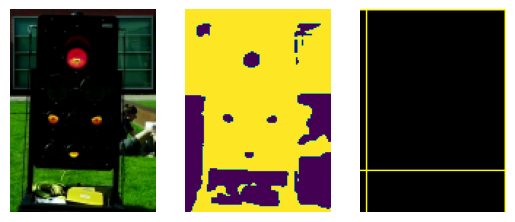

../data/drohne-signals/traffic_light0028.png
crop [(0, 2), (255, 98)] [(255, 140), (0, 14), (255, 9), (0, 4), (255, 7)]
boxes [(2, 99, 0, 139), (2, 99, 154, 162), (2, 99, 167, 173)]
crop (2, 99, 0, 139)


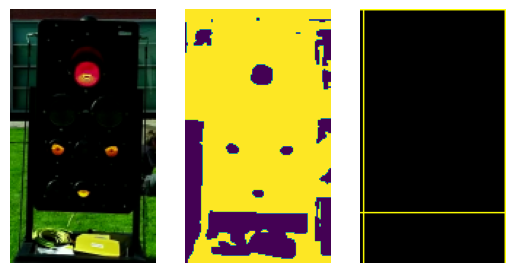

../data/drohne-signals/traffic_light0029.png
crop [(0, 1), (255, 99)] [(255, 140), (0, 13), (255, 10), (0, 4), (255, 9)]
boxes [(1, 99, 0, 139), (1, 99, 153, 162), (1, 99, 167, 175)]
crop (1, 99, 0, 139)


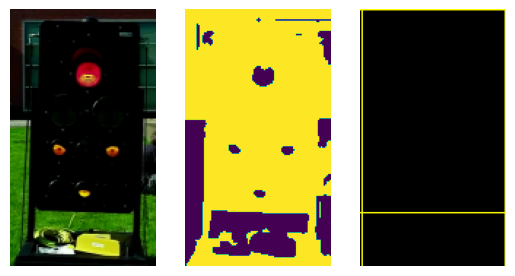

../data/drohne-signals/traffic_light0030.png
crop [(0, 3), (255, 97)] [(255, 131), (0, 13), (255, 8), (0, 5), (255, 8)]
boxes [(3, 99, 0, 130), (3, 99, 144, 151), (3, 99, 157, 164)]
crop (3, 99, 0, 130)


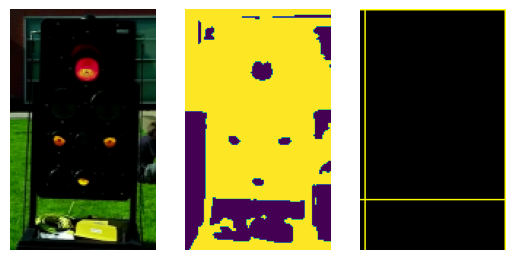

../data/drohne-signals/traffic_light0031.png
crop [(255, 100)] [(255, 163), (0, 18), (255, 16)]
boxes [(0, 99, 0, 162), (0, 99, 181, 196)]
crop (0, 99, 0, 162)


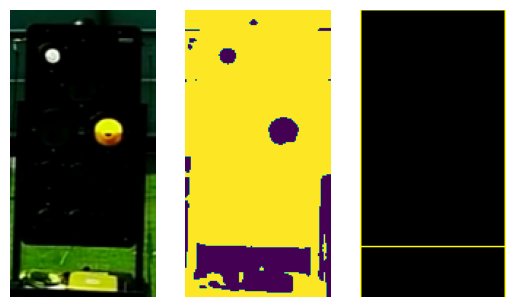

../data/drohne-signals/traffic_light0032.png
crop [(255, 100)] [(255, 165), (0, 19)]
boxes [(0, 99, 0, 164)]
crop (0, 99, 0, 164)


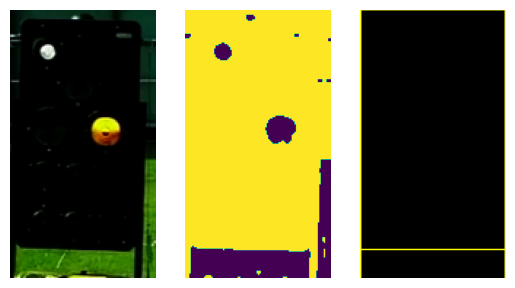

../data/drohne-signals/traffic_light0033.png
crop [(255, 100)] [(255, 165), (0, 18), (255, 12)]
boxes [(0, 99, 0, 164), (0, 99, 183, 194)]
crop (0, 99, 0, 164)


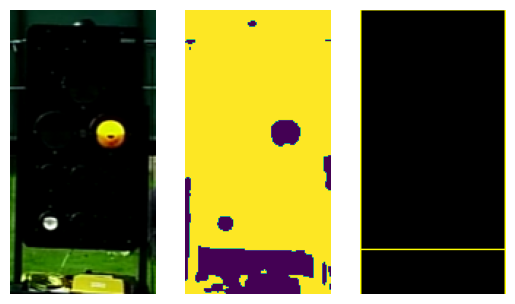

../data/drohne-signals/traffic_light0034.png
crop [(255, 100)] [(255, 159), (0, 11)]
boxes [(0, 99, 0, 158)]
crop (0, 99, 0, 158)


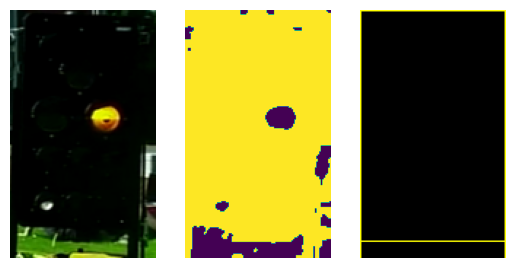

../data/drohne-signals/traffic_light0035.png
crop [(255, 100)] [(255, 164), (0, 7), (255, 5), (0, 4), (255, 13)]
boxes [(0, 99, 0, 163), (0, 99, 180, 192)]
crop (0, 99, 0, 163)


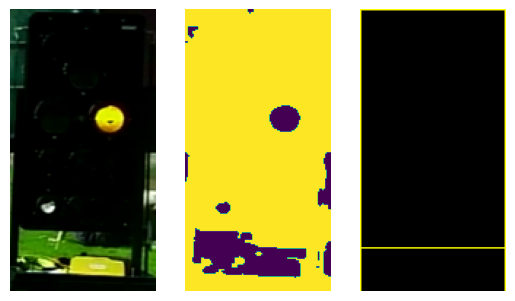

../data/drohne-signals/traffic_light0036.png
crop [(255, 100)] [(255, 170), (0, 3)]
boxes [(0, 99, 0, 169)]
crop (0, 99, 0, 169)


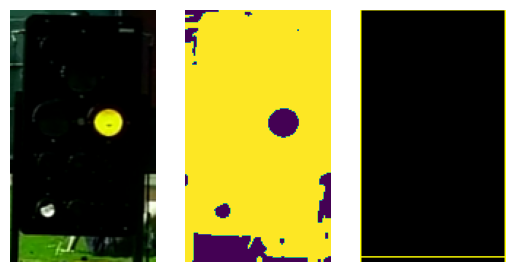

../data/drohne-signals/traffic_light0037.png
crop [(255, 100)] [(255, 172), (0, 1), (255, 3), (0, 1), (255, 20)]
boxes [(0, 99, 0, 171), (0, 99, 177, 196)]
crop (0, 99, 0, 171)


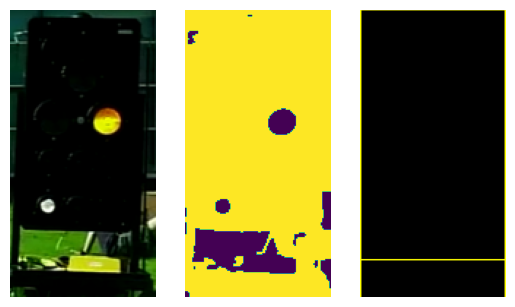

In [7]:
path = "../data/drohne-signals/"
for filename in listdir(path):
        handle_image(path + filename)